In [1]:
# from dask.distributed import Client, LocalCluster
# import logging

# cluster = LocalCluster(
#     n_workers=28,
#     threads_per_worker=8,
#     silence_logs=logging.DEBUG
# )

# client = Client(cluster, heartbeat_interval=10000)
# print(client.dashboard_link)

In [39]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev460469908


In [3]:
df = pd.read_csv(
    "../data/raw/hbn_nles_data/NLES-2020-12-27.csv"
).drop(index=0, axis="rows")
df.to_csv("../data/raw/hbn_nles_data/subjects.csv")
df.head()

,Identifiers,"NLES_SR,Administration","NLES_SR,Comment_ID","NLES_SR,Data_entry","NLES_SR,Days_Baseline","NLES_SR,EID","NLES_SR,NLES_SR_01a","NLES_SR,NLES_SR_01b","NLES_SR,NLES_SR_01c","NLES_SR,NLES_SR_02a",...,"NLES_SR,NLES_SR_TotalOccurance","NLES_SR,NLES_SR_Upset_Avg","NLES_SR,NLES_SR_Upset_Total","NLES_SR,PSCID","NLES_SR,START_DATE","NLES_SR,Season","NLES_SR,Site","NLES_SR,Study","NLES_SR,Visit_label","NLES_SR,Year"
1,"NDARAB458VK9,assessment",All,NaN,Complete,168,NDARAB458VK9,0.0,NaN,NaN,0.0,...,11,2.88,23,NaN,1901-01-01T07:00:00Z,Winter,3,HBN,NaN,2018
2,"NDARAB793GL3,assessment",All,NaN,Complete,321,NDARAB793GL3,0.0,NaN,NaN,1.0,...,9,3.60,18,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,2018
3,"NDARAC331VEH,assessment",All,NaN,Complete,88,NDARAC331VEH,0.0,NaN,NaN,1.0,...,12,1.89,17,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,2019
4,"NDARAC495TJ2,assessment",All,NaN,Complete,82,NDARAC495TJ2,0.0,NaN,NaN,1.0,...,3,4.00,8,NaN,1901-01-01T07:00:00Z,Fall,3,HBN,NaN,2018
5,"NDARAC904DMU,assessment",All,NaN,Complete,86,NDARAC904DMU,0.0,NaN,NaN,0.0,...,8,2.83,17,NaN,1901-01-01T07:00:00Z,Spring,1,HBN,NaN,2017


In [4]:
X_dwi, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/hbn_nles_data",
    target_cols=[
        "NLES_SR,NLES_SR_TotalEvents",
#         "NLES_SR_TotalOccurence",
#         "NLES_SR_Upset_Total",
#         "NLES_SR_Upset_Avg",
    ],
    index_col="NLES_SR,EID"
)

In [5]:
print(X_dwi.shape)
print(y.shape)

(1597, 3600)
(891,)


In [6]:
nles_subs = df["NLES_SR,EID"]
nles_subs_unique = df["NLES_SR,EID"].unique()
print(len(nles_subs))
missing_nles_dwi = set(nles_subs.values) - set(subjects)
print(len(missing_nles_dwi))

891
478


In [7]:
missing = pd.read_csv(
    "/Users/richford/Desktop/curation_dwi_mismatch.csv"
)
missing_subs = missing["participant_id"].values
print(len(set(missing_subs)))
print(len(set(missing_subs).intersection(missing_nles_dwi)))

512
0


In [79]:
target_col = "NLES_SR,NLES_SR_TotalOccurance"

df_y = pd.read_csv("../data/raw/hbn_nles_data/subjects.csv")
df_y = df_y[[
    "NLES_SR,EID",
    "NLES_SR,NLES_SR_TotalEvents",
    "NLES_SR,NLES_SR_TotalOccurance",
    "NLES_SR,NLES_SR_Upset_Total",
    "NLES_SR,NLES_SR_Upset_Avg",
]]
df_y = df_y.set_index("NLES_SR,EID", drop=True)
df_subs = pd.DataFrame(index=subjects)
df_subs = df_subs.merge(df_y, how="left", left_index=True, right_index=True)
y = df_subs[target_col].astype(np.float64).values
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X_dwi[nan_mask, :]

In [80]:
print(X.shape)
print(y.shape)

(413, 3600)
(413,)


(array([105., 109.,  76.,  49.,  38.,  18.,  10.,   6.,   0.,   2.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

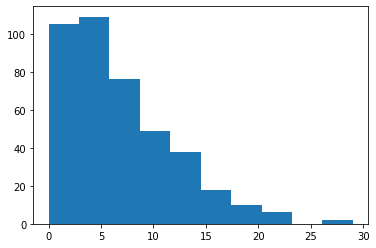

In [81]:
plt.hist(y)

In [82]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)

    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    
    gbr = GradientBoostingRegressor(n_estimators=500)
    search_space = {
        "n_estimators": [5, 50, 250, 500],
        "max_depth": Integer(1, 10),
        "learning_rate": Real(1e-2, 1, prior="log-uniform"),
        "min_samples_split": Real(0.1, 1, prior="uniform"),
        "min_samples_leaf": Real(0.1, 0.5, prior="uniform"),
        "max_features": Real(0.1, 1.0, prior="uniform"),
        "subsample": Real(0.1, 1.0, prior="uniform"),
    }
    
    steps = [
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("estimate", BayesSearchCV(
            gbr,
            search_space,
            n_iter=200,
            n_jobs=4,
        )),
    ]
    pipe_skopt = Pipeline(steps)
    
    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X, y_fit)):
        start = datetime.now()

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

#         with joblib.parallel_backend("dask"):
        pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
            "cv_results_": pipe_skopt.named_steps["estimate"].cv_results_,
            "best_estimator_": pipe_skopt.named_steps["estimate"].best_estimator_,
            "optimizer_results_": pipe_skopt.named_steps["estimate"].optimizer_results_,
        }
        
        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [83]:
results = {}
results[target_col + ",gradient_boosting"] = get_cv_results(
    n_splits=5,
    n_repeats=1,
    power_transformer=False,
    shuffle=False,
)

# with open("hbn_nles_regression.pkl", "rb") as fp:
#     results = pickle.load(fp)

CV index [  0], Elapsed time:  0:28:04.008619
CV index [  1], Elapsed time:  0:20:04.981559
CV index [  2], Elapsed time:  0:43:21.213462
CV index [  3], Elapsed time:  0:19:44.367726
CV index [  4], Elapsed time:  0:32:26.456149


In [87]:
with open("hbn_nles_regression.pkl", "wb") as fp:
    pickle.dump(results, fp)

In [88]:
results.keys()

dict_keys(['NLES_SR,NLES_SR_TotalOccurance,gradient_boosting'])

In [89]:
for key, res in results.items():
    test_mae = [cvr["test_mae"] for cvr in res[0].values()]
    train_mae = [cvr["train_mae"] for cvr in res[0].values()]
    test_r2 = [cvr["test_r2"] for cvr in res[0].values()]
    train_r2 = [cvr["train_r2"] for cvr in res[0].values()]
    print(key, "test MAE :", np.mean(test_mae))
    print(key, "train MAE:", np.mean(train_mae))
    print(key, "test R2  :", np.mean(test_r2))
    print(key, "train R2 :", np.mean(train_r2))

NLES_SR,NLES_SR_TotalOccurance,gradient_boosting test MAE : 3.65742480205389
NLES_SR,NLES_SR_TotalOccurance,gradient_boosting train MAE: 3.478568961204167
NLES_SR,NLES_SR_TotalOccurance,gradient_boosting test R2  : -0.04589596938234468
NLES_SR,NLES_SR_TotalOccurance,gradient_boosting train R2 : 0.11589351869441107


In [91]:
pred_results = results[target_col + ",gradient_boosting"][0]
df_results = pd.concat([
    pd.DataFrame.from_dict(
        {
            k: v for k, v in bag_res.items()
            if k in ["test_idx", "y_pred", "y_true"]
        }
    ).set_index(keys="test_idx", drop=True)
    for bag_res in pred_results.values()
]).sort_index()

df_results["residual"] = df_results["y_true"] - df_results["y_pred"]
df_results["std_residual"] = df_results["residual"] / np.std(df_results["residual"])

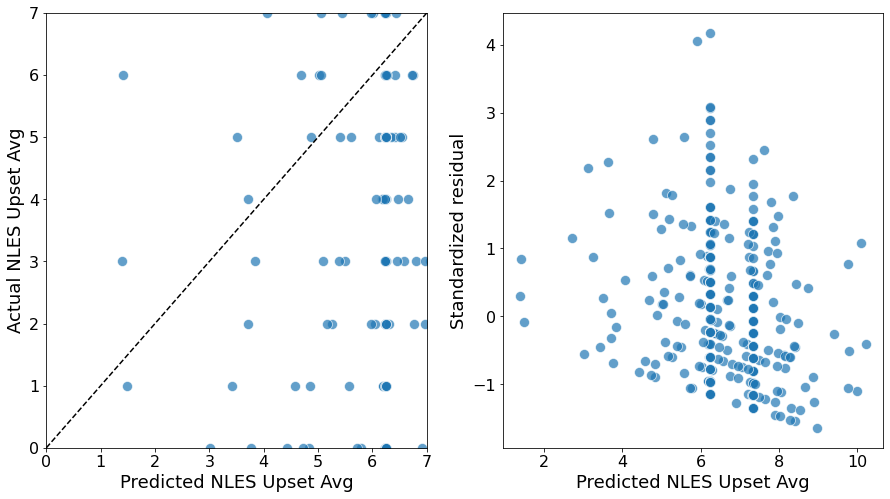

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

sns.scatterplot(x="y_pred", y="y_true", data=df_results, ax=ax[0], s=100, alpha=0.7)
sns.scatterplot(x="y_pred", y="std_residual", data=df_results, ax=ax[1], s=100, alpha=0.7)

_ = ax[0].set_ylabel("Actual NLES Upset Avg", fontsize=18)
_ = ax[1].set_ylabel("Standardized residual", fontsize=18)

for axis in ax:
    _ = axis.set_xlabel("Predicted NLES Upset Avg", fontsize=18)
    _ = axis.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = axis.tick_params(axis = 'both', which = 'minor', labelsize = 12)

xmin = 0
xmax = 7
_ = ax[0].autoscale(False)
_ = ax[0].plot([xmin, xmax], [xmin, xmax], color="black", ls="--")
_ = ax[0].set_xlim(xmin, xmax)
_ = ax[0].set_ylim(xmin, xmax)

# fig.savefig("cc_regression_results.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(1, 1)

for ax, (key, df) in zip(axes[0], df_scatter.items()):
    sns.scatterplot(x="y_true", y="y_pred", data=df, ax=ax, s=20, alpha=0.7)

    _ = ax.set_xlabel("Actual age", labelpad=-0.3)
    _ = ax.autoscale(False)
    _ = ax.plot([0, 200], [0, 200], color="black", ls="--", marker="")
    _ = ax.text(
        0.98, 0.02,
        "\n".join([
            r"$R^2={0:4.2f}$".format(r2_score(df["y_true"], df["y_pred"])),
            r"$MAE={0:4.2f}$".format(median_absolute_error(df["y_true"], df["y_pred"]))
        ]),
        ha="right", va="bottom",
        transform=ax.transAxes,
        fontweight="bold",
    )
    _ = ax.set_title(titles[key])
    _ = ax.tick_params(axis='both', which='major')
    _ = ax.tick_params(axis='both', which='minor')
    
_ = axes[0, 0].set_ylabel("Predicted age")
_ = axes[0, 1].set_ylabel(None)
_ = axes[0, 2].set_ylabel(None)

for ax in axes[1]:
    _ = ax.axis("off")

for ax, alpha in zip(axes[0], "ace"):
    ax.text(  # position text relative to Axes
        0.0, 1.0, alpha,
        ha="center", va="center",
        transform=ax.transAxes,
        fontweight="bold",
        bbox=dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round,pad=0.25"
        )
    )

for ax, alpha in zip(axes[1], "bdf"):
    ax.text(  # position text relative to Axes
        0.0, 0.97, alpha,
        ha="center", va="center",
        transform=ax.transAxes,
        fontweight="bold",
        bbox=dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round,pad=0.25"
        )
    )
    
fig.savefig(op.join(fig_dir, "regression_scatter.pdf"), bbox_inches="tight")